In [146]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

## 1. Линейная регрессия. Реализация

In [147]:
data = load_boston()
data['data'].shape

(506, 13)

In [148]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 1.1. Реализация линейной регрессии с использованием матричных операций

Линейная регрессия выражается следующей зависимостью:
$$y=X\theta+\epsilon,$$
где $X$ — матрица объекты-признаки, $y$ — вектор целевых значений, соответствующих $X$, $\theta$ — параметр линейной регрессии, $\epsilon$ — некоторый шум.

Из данного следует выражение для $\theta$ как:
$$X^Ty=X^TX\theta \rightarrow \theta=(X^TX)^{-1}X^Ty$$

Реализуем выражение для $\theta$ с помощью операций линейной алгебры библиотеки Numpy:

In [296]:
# ЗАДАЧА Реализовать функцию, осуществляющую матричные операции для получения theta
def linreg_linear(X, y):
    theta = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)
    
    return theta

In [308]:
# Подготовить данные

X, y = data['data'], data['target']
#X = (X - X.mean(axis=0)) / X.std(axis=0)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

In [309]:
#np.max(X.std(axis=0))
#X= X[X[:,12]>=50]
# = X[:,-1]
#=X[:,:-1]

In [310]:
# Вычислить параметр theta
theta = linreg_linear(X, y)

In [311]:
theta.shape

(14,)

In [312]:
# Сделать предсказания для тренировочной выборки
y_pred = X.dot(theta)

In [313]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

In [314]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


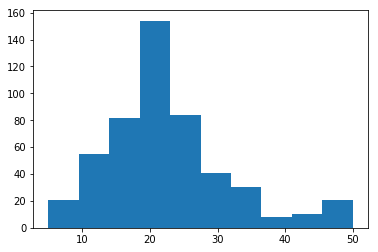

In [315]:
plt.hist(y);

In [316]:
# Разбить выборку на train/valid, вычислить theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = linreg_linear(X_train, y_train)
y_pred = X_valid.dot(theta)
y_train_pred = X_train.dot(theta)

In [317]:
print_regression_metrics(y_valid, y_pred)
print_regression_metrics(y_train, y_train_pred)

MSE = 20.88, RMSE = 4.57
MSE = 22.37, RMSE = 4.73


In [318]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


### 1.2. Реализация линейной регрессии с использованием методов оптимизации

Для реализации линейной регрессии с помощью методов оптимизации будем использовать функцию ошибки **среднего квадратичного** ([Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)), которая является выпуклой функцией в n-мерном пространстве $\mathbb{R}^n$ и в общем виде выглядит следующим образом:
$$MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - a(x_i))^2}.$$
Здесь $x_i$ — вектор-признак $i$-го объекта обучающей выборки, $y_i$ — истинное значение для $i$-го объекта, $a(x)$ — алгоритм, предсказывающий для данного объекта $x$ целевое значение, $n$ — кол-во объектов в выборке.

В случае линейной регрессии $MSE$ представляется как:
$$MSE(X, y, \theta) = \frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} = \frac{1}{2n} \lVert{y - X\theta}\rVert_{2}^{2}=\frac{1}{2n} (y - X\theta)^T(y - X\theta),$$
где $\theta$ — параметр модели линейной регрессии, $X$ — матрица объекты-признаки, $y$ - вектор истинных значений, соответствующих $X$.

Возьмем первый вариант представления функции ошибки и посчитаем ее градиент по параметру $\theta$, предварительно переименовав $MSE$ в $L$:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2}$$
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} = \frac{1}{n}X^T(X\theta - y)$$

Исходя из полученного выражения градиента, реализуем алгоритм градиентного спуска:

In [161]:
# Реализовать функцию вычисления градиента функции MSE

def calc_mse_gradient(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
    
    return grad

In [162]:
# Реализовать функцию, осуществляющую градиентный шаг
# (функция должна содержать параметр величины шага alpha - learning rate)

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

In [163]:
# Реализовать функцию цикла градиентного спуска с доп. параметрами
# начального вектора theta и числа итераций

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta


In [164]:
# Разбить таблицу данных на матрицы X и y
X, y = data['data'], data['target']

# Добавить фиктивный столбец единиц (bias линейной модели)
#X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [165]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)

In [166]:
theta

array([  3.31891427e+247,   7.38542912e+247,   8.95058180e+247,
         5.06877366e+245,   4.21448022e+246,   4.62454777e+247,
         5.28353598e+248,   2.65276630e+247,   8.18859653e+247,
         3.26684487e+249,   1.38172850e+248,   2.63958173e+249,
         9.87470759e+247])

In [167]:
# Проверить максимальные значения по каждому признаку в данных
X.max(axis=0)

array([  88.9762,  100.    ,   27.74  ,    1.    ,    0.871 ,    8.78  ,
        100.    ,   12.1265,   24.    ,  711.    ,   22.    ,  396.9   ,
         37.97  ])

In [168]:
print(data['feature_names'][np.argmax(X.std(axis=0)) + 1])
print(np.max(X.std(axis=0)))

PTRATIO
168.370495039


In [169]:
# Нормализовать даннные с помощью стандартной нормализации
X, y = data['data'], data['target']
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [170]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
X.max(axis=0)

array([ 1.        ,  9.9339306 ,  3.80423444,  2.42256516,  3.66839786,
        2.73234648,  3.55504427,  1.11749449,  3.96051769,  1.66124525,
        1.79819419,  1.63882832,  0.44105193,  3.54877081])

In [171]:
# Оптимизировать theta на новых данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 5000)

ValueError: shapes (506,14) and (13,) not aligned: 14 (dim 1) != 13 (dim 0)

In [ ]:
theta

In [ ]:
# Сделать предсказания при полученных параметрах
y_pred = X.dot(theta)

In [ ]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

In [ ]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_avalid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_mse_gradient, np.ones(m), 0.01, 5000)
y_pred = X_valid.dot(theta)

print_regression_metrics(y_valid, y_pred)